In [3]:
#Imports
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [4]:
#Base Params
stepsPerSec = 10

COLOR = 'black'         #lightGray
BACKGROUND = "none"     #black
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['axes.facecolor'] = BACKGROUND
plt.rcParams['figure.facecolor'] = BACKGROUND

## Importing base emission values to dfBase

In [5]:
xmlDataBase = open('./emissionBaseValues_Bckp.xml', 'r').read()  # Read file
rootBase = ET.XML(xmlDataBase)  # Parse XML

colsBase = []
dataBase = []
for i in rootBase:
    line = []
    for fuelInfo in i:
        # print(i.attrib["time"] + " " + fuelinfo.attrib["id"] + " " + str(fuelinfo.attrib["fuel"]))
        line.append(float(fuelInfo.attrib["fuel"]) / stepsPerSec)

        if (fuelInfo.attrib["id"] not in colsBase):
            colsBase.append(fuelInfo.attrib["id"])
    dataBase.append(line)

dfBase = pd.DataFrame(dataBase)
dfBase.columns = colsBase
# print(dfBase)


#### Total consumption of each car

Text(0.5, 1.0, 'Total consumption of each car')

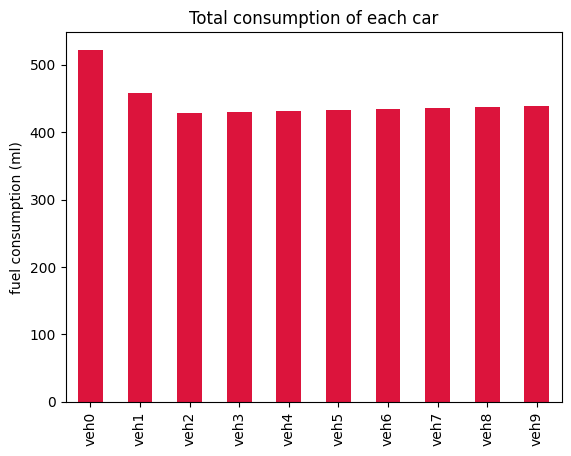

In [6]:
baseSum = dfBase.sum(0)
# print(summed)
baseSum.plot(kind="bar", color="crimson")
plt.ylabel("fuel consumption (ml)")
plt.title("Total consumption of each car")

## Importing emission scaling values to dfScale

In [7]:
xmlDataScale = open("./emissionScaleValues_Bckp.xml", "r").read()
rootScale = ET.XML(xmlDataScale)

colsScale = []
dataScale = []
for i in rootScale:
    line = []
    for scaleInfo in i:
        line.append(float(scaleInfo.attrib["scaling"]))

        if (scaleInfo.attrib["id"] not in colsScale):
            colsScale.append(scaleInfo.attrib["id"])
    dataScale.append(line)
dfScale = pd.DataFrame(dataScale)
dfScale.columns = colsScale
# print(dfScale)

#### Total scaling values of each car

<AxesSubplot: >

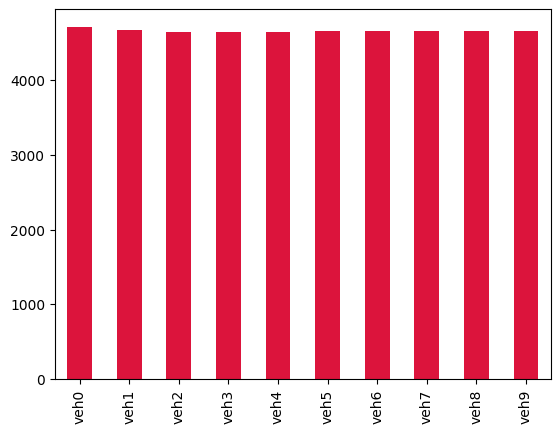

In [8]:
scaledSum = dfScale.sum(0)
# print(scaledSum)
scaledSum.plot(kind="bar", color="crimson")

## Scaling base consumptions for simulated savings

In [9]:
vehicles = dfBase.columns
rowsBase = len(dfBase.index)
rowsScale = len(dfScale.index)
rowsSmaller = rowsBase if rowsBase < rowsScale else rowsScale

dataBaseScaled = []

for i in range(rowsSmaller):
    line = []
    for veh in vehicles:
        b = dfBase[veh][i]
        s = dfScale[veh][i]
        bsd = b*s
        line.append(bsd)
    dataBaseScaled.append(line)

dfBaseScaled = pd.DataFrame(dataBaseScaled, columns=vehicles)

#### Total consumed fuel of each car (controlled, ml)

veh0    479.08960
veh1    420.75900
veh2    389.06830
veh3    390.21000
veh4    391.34475
veh5    392.69200
veh6    393.82335
veh7    394.95725
veh8    396.29005
veh9    397.41460
dtype: float64


Text(0.5, 1.0, 'Scaled total consumption of controlled cars')

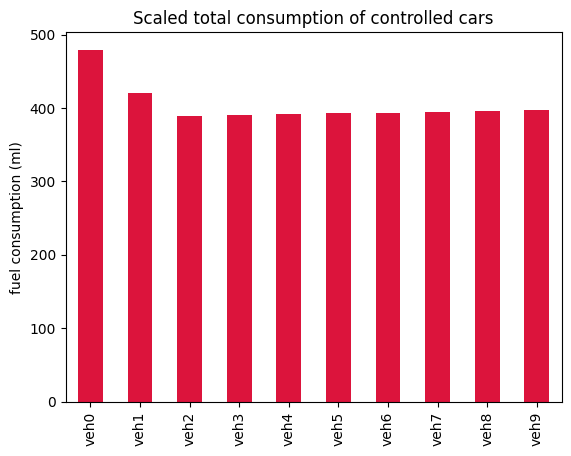

In [10]:
baseScaledSum = dfBaseScaled.sum(0)
print(baseScaledSum)
baseScaledSum.plot(kind="bar", color="crimson")
plt.ylabel("fuel consumption (ml)")
plt.title("Scaled total consumption of controlled cars")

## Importing emission values of uncontrolled cars 

In [11]:
xmlDataUnc = open('./emissionBaseValues_Uncontrolled_Bckp.xml', 'r').read()  # Read file
rootUnc = ET.XML(xmlDataUnc)  # Parse XML

colsUnc = []
dataUnc = []
for i in rootUnc:
    line = []
    for fuelInfo in i:
        # print(i.attrib["time"] + " " + fuelinfo.attrib["id"] + " " + str(fuelinfo.attrib["fuel"]))
        line.append(float(fuelInfo.attrib["fuel"]) / stepsPerSec)

        if (fuelInfo.attrib["id"] not in colsUnc):
            colsUnc.append(fuelInfo.attrib["id"])
    dataUnc.append(line)

dfUnc = pd.DataFrame(dataUnc)
dfUnc.columns = colsUnc

#### Total consumed fuel of each car (uncontrolled, ml)

Text(0.5, 1.0, 'Total consumption uncontrolled cars')

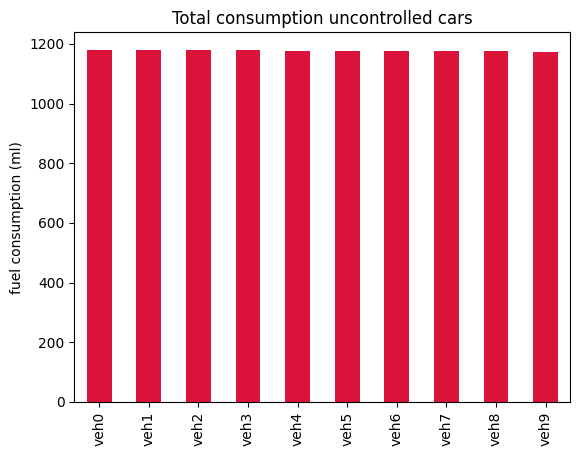

In [12]:
uncSum = dfUnc.sum(0)
# print(summed)
uncSum.plot(kind="bar", color="crimson")
plt.ylabel("fuel consumption (ml)")
plt.title("Total consumption uncontrolled cars")
# ax = plt.gca()
# ax.set_facecolor('xkcd:salmon')